In [1]:
# Importing libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.data import AUTOTUNE

train_dir = 'C:/strokeds/Stroke Dataset V3.1/train'


#check for GPU availability (if available, it uses CUDA)

if tf.test.gpu_device_name():
    print('GPU is available.')
else:
    print('No GPU detected.')

No GPU detected.


In [2]:
#define the training data

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    subset="training",
    validation_split=0.9, #percentage of data used for training
    seed=123,
    image_size=(180, 180),
    batch_size=32,#how many images used per epoch before parameters are updated
    color_mode="grayscale")


Found 4280 files belonging to 2 classes.
Using 428 files for training.


In [3]:
test_dir = 'C:/strokeds/Stroke Dataset V3.1/test'

In [4]:
# Testing or Validation split
val_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    subset="validation",
    validation_split=0.9,
    seed=123,
    image_size=(180,180),
    batch_size=32,
    color_mode="grayscale")


Found 922 files belonging to 2 classes.
Using 829 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['Hemorrhagic', 'ischemic']


In [6]:
#data augmentation (since this dataset is very small, augmentation is a must)

img_height = 180
img_width = 180
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  1)),
    layers.RandomRotation(0.1), #10% chance of being rotated
    layers.RandomZoom(0.1),
  ]
)

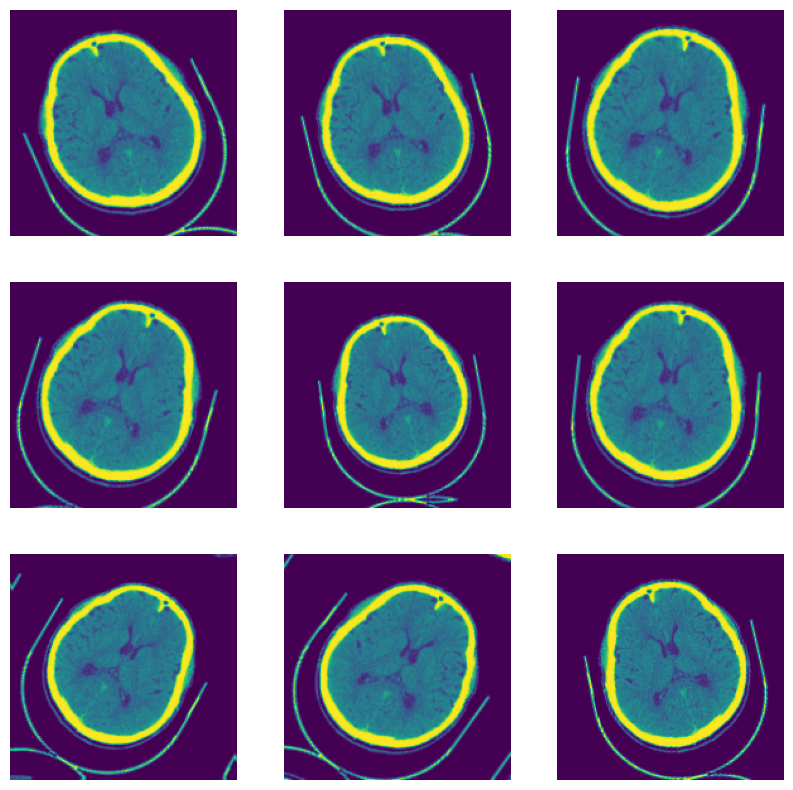

In [7]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [15]:
from tensorflow.keras import regularizers

num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(180, 180, 1)),
  layers.Conv2D(16, 3, strides=2, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu', activity_regularizer=regularizers.L2(0.01)),
  layers.BatchNormalization(),
  layers.Dense(1, activation='sigmoid', activity_regularizer=regularizers.L2(0.01))
])

In [16]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 1)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 16)        160       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 45, 45, 16)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 32400)             0         
                                                                 
 dense_4 (Dense)             (None, 128)               4147328   
                                                                 
 batch_normalization_2 (Bat  (None, 128)               512       
 chNormalization)                                     

In [17]:
epochs=15
model.fit(
train_ds,
validation_data=val_ds,
epochs=epochs
)


Epoch 1/15
14/14 [==============================] - 5s 221ms/step - loss: 0.7193 - accuracy: 0.5748 - val_loss: 0.6944 - val_accuracy: 0.5525
Epoch 2/15
14/14 [==============================] - 3s 211ms/step - loss: 0.5071 - accuracy: 0.7593 - val_loss: 0.6882 - val_accuracy: 0.6622
Epoch 3/15
14/14 [==============================] - 3s 220ms/step - loss: 0.3766 - accuracy: 0.8692 - val_loss: 0.6832 - val_accuracy: 0.7045
Epoch 4/15
14/14 [==============================] - 3s 215ms/step - loss: 0.3083 - accuracy: 0.9299 - val_loss: 0.6775 - val_accuracy: 0.7226
Epoch 5/15
14/14 [==============================] - 3s 222ms/step - loss: 0.2665 - accuracy: 0.9322 - val_loss: 0.6712 - val_accuracy: 0.7624
Epoch 6/15
14/14 [==============================] - 4s 248ms/step - loss: 0.2110 - accuracy: 0.9790 - val_loss: 0.6663 - val_accuracy: 0.8022
Epoch 7/15
14/14 [==============================] - 3s 208ms/step - loss: 0.1810 - accuracy: 0.9883 - val_loss: 0.6616 - val_accuracy: 0.8034
Epoch 

In [ ]:
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output
from PIL import Image
import io


upload_button = widgets.FileUpload(accept='.jpg,.png', multiple=False)
image_output = widgets.Output()
prediction_output = widgets.Output()

# Define prediction function
def predict_image(change):
    image_output.clear_output()
    prediction_output.clear_output()
    
    if len(upload_button.value) == 0:
        with prediction_output:
            print("Please upload an image.")
        return
    
    uploaded_image = upload_button.value[0]
    image_content = uploaded_image['content']
    image = Image.open(io.BytesIO(image_content)).convert('L')
    image = image.resize((180, 180))
    img_array = tf.keras.utils.img_to_array(image)
    img_array = tf.expand_dims(img_array, 0)
    
    with image_output:
        display(image)
    
    with prediction_output:
        predictions = model.predict(img_array)
        score = float(predictions[0])

    print(f"This image is {100 * (1-score):.2f}% Hemorrhagic and {100 * score:.2f}% ischemic.")

# Attach function to button click event
upload_button.observe(predict_image, names='value')

# Display widgets
display(widgets.Label("Upload an image:"))
display(upload_button)
display(image_output)
display(widgets.Label("Prediction:"))
display(prediction_output)